### 2.3. Model II

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
import os
import sys

# Load modules from the lib directory
sys.path.insert(0, "../lib")
from resnet import load_resnet, ResNet18
from lossFunctions import get_custom_cross_entropy, l1_loss
from model2 import LabelCleaner, ImageClassifier

In [ ]:
if not os.path.exists("./drive"):
    drive.mount('/content/drive')

if not os.path.exists("../data"):
    os.mkdir("../data")

# loading the temp.zip and creating a zip object
with ZipFile("./drive/MyDrive/train_data.zip", 'r') as zip_object:

    # Extracting all the members of the zip 
    # into a specific location.
    zip_object.extractall(path="../data")


In [ ]:
# [DO NOT MODIFY THIS CELL]

n_images: int = 50_000
n_noisy: int = 40_000
n_clean: int = n_images - n_noisy

images : np.ndarray = np.empty((n_images, 32, 32, 3), dtype=np.float32)

# Load the data
for i in range(n_images):
    image_path = f"../data/images/{i+1:05d}.png"
    images[i,:,:,:] = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

In [ ]:
test_ratio: float = 0.2
train_size: float = n_images - (n_clean * test_ratio)
clean_noisy_ratio: float = 1 / 9
train_clean_size: int = int(np.floor(train_size * clean_noisy_ratio))
val_clean_size: int = int(np.floor((n_clean * (1 - test_ratio)) - train_clean_size))
test_clean_size: int = n_clean - train_clean_size - val_clean_size

IMG_SIZE: int = 32
IMG_SHAPE: tuple = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE: int = 128

In [ ]:
images_normalized = tf.cast(images, dtype = tf.float32) / 255.0
clean_labels_one_hot = tf.one_hot(clean_labels, depth = 10)
noisy_labels_one_hot = tf.one_hot(noisy_labels, depth = 10)

In [ ]:
x_clean = images_normalized[:n_clean]
y_clean = clean_labels_one_hot
x_noisy = images_normalized[n_clean:]
y_noisy = noisy_labels_one_hot

In [ ]:
x_clean_train_full, x_clean_test, y_clean_train_full, y_clean_test = train_test_split(x_clean.numpy(), y_clean.numpy(), test_size = 0.1) 

In [ ]:
x_clean_train, x_clean_val, y_clean_train, y_clean_val = train_test_split(x_clean_train_full, y_clean_train_full, test_size = 0.2) 

In [ ]:
x_clean_train_size = len(x_clean_train)
x_clean_val_size = len(x_clean_val)
x_clean_test_size = len(x_clean_test)

In [ ]:
V = tf.data.Dataset.from_tensor_slices((
    (
        x_clean_train_full,
        noisy_labels_one_hot[:len(y_clean_train_full)]
    ),
    y_clean_train_full
))
V_test = tf.data.Dataset.from_tensor_slices((
    (
        x_clean_test,
        noisy_labels_one_hot[x_clean_train_size + x_clean_val_size:10000]
    ),
    y_clean_test
)).batch(batch_size = BATCH_SIZE)

In [ ]:
V_train = V.take(x_clean_train_size).batch(batch_size = BATCH_SIZE)
V_val = V.skip(x_clean_train_size).take(x_clean_val_size).batch(batch_size = BATCH_SIZE)
del V

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)

In [ ]:
cnn_1 = load_resnet(10, (32, 32, 3))
cnn_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)
cnn_1.trainable = False

In [ ]:
cnn_1.evaluate(x_clean_test, y_clean_test)

32/32 [==============================] - 2s 10ms/step - loss: 0.3171 - accuracy: 0.9110


[0.31712672114372253, 0.9110000133514404]

In [ ]:
cnn_1.trainable = False
cleaner = LabelCleaner(cnn_1)

cleaner.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = l1_loss,
    metrics = ['accuracy']
)

In [ ]:
cleaner.fit(
    V_train,
    epochs = 60,
    validation_data = V_val,
    callbacks = [es]
)

Epoch 1/60
57/57 [==============================] - 3s 25ms/step - loss: 144.2127 - accuracy: 0.6825 - val_loss: 147.1830 - val_accuracy: 0.5156
Epoch 2/60
57/57 [==============================] - 1s 14ms/step - loss: 40.1163 - accuracy: 0.8618 - val_loss: 102.0742 - val_accuracy: 0.7211
Epoch 3/60
57/57 [==============================] - 1s 14ms/step - loss: 33.7128 - accuracy: 0.8629 - val_loss: 76.0516 - val_accuracy: 0.8339
Epoch 4/60
57/57 [==============================] - 1s 14ms/step - loss: 32.9007 - accuracy: 0.8635 - val_loss: 55.0190 - val_accuracy: 0.8639
Epoch 5/60
57/57 [==============================] - 1s 14ms/step - loss: 32.2837 - accuracy: 0.8650 - val_loss: 41.2236 - val_accuracy: 0.8661
Epoch 6/60
57/57 [==============================] - 1s 14ms/step - loss: 31.7482 - accuracy: 0.8664 - val_loss: 35.3415 - val_accuracy: 0.8656
Epoch 7/60
57/57 [==============================] - 1s 14ms/step - loss: 31.3158 - accuracy: 0.8668 - val_loss: 33.2966 - val_accuracy: 0.8

In [ ]:
cleaner.evaluate(V_test)
cleaner.trainable = False

8/8 [==============================] - 0s 18ms/step - loss: 18.5810 - accuracy: 0.9230


In [ ]:
c_train_full = tf.nn.softmax(
    cleaner.predict([
        images_normalized,
        y_noisy
    ])
)

1563/1563 [==============================] - 10s 6ms/step


In [ ]:
cnn_1.trainable = False
# image_classifier = tf.keras.Sequential([
#     cnn_1,
#     tf.keras.layers.Dense(units = 512),
#     tf.keras.layers.Dense(units = 10, activation = "sigmoid")
# ])
image_classifier = ImageClassifier(cnn_1)

image_classifier.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics = ['accuracy']
)

In [ ]:
def ImageClassifier(cnn: tf.keras.Model) -> tf.keras.Model:
    """
    Build a new model that takes images as input and outputs class probabilities.

    Parameters:
    -----------

    `cnn: tf.keras.Model` 
        The base CNN model to use.

    `return`
        The new model.
    """
    return tf.keras.Sequential([
        cnn,
        tf.keras.layers.Dense(units = 64),
        tf.keras.layers.Dense(units = 10, activation = "sigmoid")
    ])

In [ ]:
image_classifier.fit(
    images_normalized,
    c_train_full,
    epochs = 30,
    batch_size = BATCH_SIZE,
)

Epoch 1/30
391/391 [==============================] - 6s 11ms/step - loss: 2.2450 - accuracy: 0.8976
Epoch 2/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9390
Epoch 3/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9390
Epoch 4/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9394
Epoch 5/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9393
Epoch 6/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9390
Epoch 7/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9391
Epoch 8/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9391
Epoch 9/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accuracy: 0.9389
Epoch 10/30
391/391 [==============================] - 4s 10ms/step - loss: 2.2386 - accura

In [ ]:
image_classifier.fit(
    x_clean_train,
    y_clean_train,
    epochs = 30,
    batch_size = BATCH_SIZE,
    validation_data = (x_clean_val, y_clean_val),
    callbacks = [es]
)

Epoch 1/30
57/57 [==============================] - 1s 25ms/step - loss: 0.5831 - accuracy: 0.9244 - val_loss: 0.3229 - val_accuracy: 0.9222
Epoch 2/30
57/57 [==============================] - 1s 13ms/step - loss: 0.3031 - accuracy: 0.9276 - val_loss: 0.3202 - val_accuracy: 0.9217
Epoch 3/30
57/57 [==============================] - 1s 13ms/step - loss: 0.2979 - accuracy: 0.9281 - val_loss: 0.3195 - val_accuracy: 0.9228
Epoch 4/30
57/57 [==============================] - 1s 13ms/step - loss: 0.2960 - accuracy: 0.9282 - val_loss: 0.3192 - val_accuracy: 0.9211
Epoch 5/30
57/57 [==============================] - 1s 13ms/step - loss: 0.2949 - accuracy: 0.9290 - val_loss: 0.3185 - val_accuracy: 0.9222
Epoch 6/30
57/57 [==============================] - 1s 12ms/step - loss: 0.2939 - accuracy: 0.9287 - val_loss: 0.3192 - val_accuracy: 0.9222
Epoch 7/30
57/57 [==============================] - 1s 13ms/step - loss: 0.2931 - accuracy: 0.9285 - val_loss: 0.3201 - val_accuracy: 0.9222
Epoch 8/30
57

In [ ]:
image_classifier.evaluate(images_normalized, c_train_full)

1563/1563 [==============================] - 12s 8ms/step - loss: 4.3865 - accuracy: 0.9573


[4.386488914489746, 0.9573400020599365]

In [ ]:
image_classifier.save_weights("image_classifier/image_classifier")

In [ ]:
image_classifier(images_normalized[10001, :].numpy().reshape(1, 32, 32, 3))

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.07706565, 0.13732249, 0.51214194, 0.81049645, 0.23788972,
        0.29260194, 0.99920964, 0.40492126, 0.14081003, 0.241903  ]],
      dtype=float32)>

In [ ]:
preds = image_classifier.predict(x_noisy)


1250/1250 [==============================] - 8s 6ms/step


In [ ]:
probs = tf.nn.softmax(preds)

In [ ]:
labels = tf.argmax(probs, 1)

In [ ]:
labels.numpy()[:100]

array([8, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 5, 6, 6, 5, 4, 8, 5, 2, 6, 0, 3,
       1, 4, 0, 3, 0, 0, 7, 7, 9, 0, 6, 5, 6, 1, 8, 5, 9, 1, 7, 7, 8, 0,
       2, 7, 4, 9, 2, 0, 0, 3, 6, 6, 0, 4, 9, 2, 6, 4, 5, 0, 4, 3, 0, 8,
       3, 2, 8, 8, 3, 1, 5, 7, 1, 9, 4, 7, 9, 9, 1, 7, 3, 5, 7, 3, 3, 8,
       4, 5, 1, 2, 9, 2, 7, 0, 8, 6, 8, 8])

(array([6072., 4927., 5064., 4835., 4743., 4949., 4445., 4505., 5157.,
        5303.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

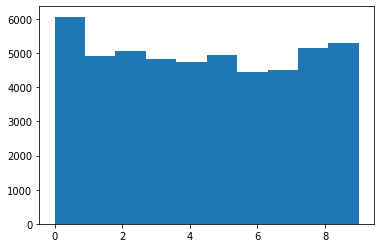

In [ ]:
plt.hist(tf.argmax(c_train_full, 1))

In [ ]:
classes = (
"airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"
)

In [ ]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    image_classifier.load_weights("image_classifier/image_classifier")


    pred = image_classifier(image.numpy().reshape(1, 32, 32, 3))
    label = int(tf.argmax(pred, 1))

    return label



In [ ]:
classes[model_II(x_noisy[1])]

'frog'